# Community Detection on Zachary’s Karate Club (Label Propagation)

This notebook runs the **Label Propagation** community detection algorithm (the `community_detection` class you provided) on **Zachary’s Karate Club** graph.

It’s written to be **step-by-step**: we’ll
1. Load the algorithm,
2. Load and visualize the Karate Club graph,
3. Initialize labels,
4. Run label propagation **one iteration at a time**, showing what changes,
5. Visualize the evolving communities,
6. Report final communities and compare to the classic “club split” attribute.

## 1) Setup

We’ll use:
- `networkx` for the Karate Club graph,
- `matplotlib` for plotting,

In [96]:
from rice_ml.unsupervised_learning.community_detection  import community_detection
import matplotlib.pyplot as plt
import random
from collections import Counter, defaultdict
import networkx as nx
from typing import Dict, Iterable, Hashable, Tuple


## 2) Load Zachary’s Karate Club graph

NetworkX provides this graph built-in as `nx.karate_club_graph()`.
Nodes are labeled `0..33` (34 members).
We split the graph into nodes (called V) and edges (called E)

In [97]:
G = nx.karate_club_graph()
V = G.nodes
E = G.edges
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Example node attributes for node 0:", G.nodes[0])

Number of nodes: 34
Number of edges: 78
Example node attributes for node 0: {'club': 'Mr. Hi'}


## 3)  Visualize the graph uncolored

We’ll draw the graph using a fixed layout so later plots are easy to compare.

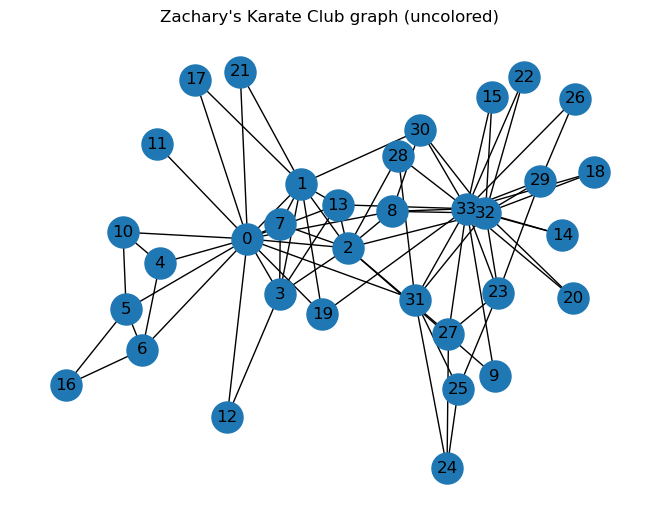

In [98]:
pos = nx.spring_layout(G, seed=7)  # fixed seed so the layout is stable across runs

plt.figure()
nx.draw(G, pos, with_labels=True, node_size=500)
plt.title("Zachary's Karate Club graph (uncolored)")
plt.show()

## 4) Setting up the Algorithm
We have made our sets of verticies (V) and edges (E)
Our implementation expects:
- `V`: an iterable of nodes
- `E`: an iterable of undirected edges `(i, j) for i,j in V`
And also expects parameters:
- `max_iters`: maximum number of label propagation iterations
- `epsilon`: early termination threshold (the fraction of nodes whose labels changed in one iteration)
Now we can print V and E to see what they contain
We will call our model "model"
We will fix our model seed to be "42" for reproducibility  

In [99]:
print("Vertices (V):", V)
print("Edges (E):", E)
max_iters = 50 #we define max_iters outside of "model" because we use this value later on for ploting
model = community_detection(vertices=V , edges=E , max_iters=max_iters, epsilon=10**(-16)) #initialize our model



Vertices (V): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Edges (E): [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]


## 5) Step-by-step label propagation

The class has a `run()` method that executes the whole process.
But for learning, we’ll do it manually by calling the internal helpers:

- `model._initialize_labels()` assigns each node its own unique label.
- `model._single_iteration()` performs **one** label propagation pass and returns the fraction of nodes that changed.

> Note: Methods starting with `_` are “internal” by convention. We’re calling them here on purpose to expose the algorithm’s mechanics.

In [100]:
# Reproducible randomness inside the algorithm
#random.seed(42)
initial_labels = model._initialize_labels()

# Show a few initial labels (each node starts with its own unique label)
print("Initial labels:", initial_labels)
print("Number of distinct labels initially:", len(set(model._labels.values())))

Initial labels: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33}
Number of distinct labels initially: 34


## 6) Helper functions for reporting + plotting

We’ll create a couple helpers to:
- group nodes by label into communities,
- compute a nice summary,
- draw the graph colored by current labels.

In [101]:
def labels_to_communities(labels_dict):
    comms = defaultdict(list)
    for node, lbl in labels_dict.items():
        comms[lbl].append(node)
    # sort nodes in each community for readability
    for lbl in comms:
        comms[lbl] = sorted(comms[lbl])
    return dict(comms)

def summarize_labels(labels_dict):
    counts = Counter(labels_dict.values())
    return {
        "num_communities": len(counts),
        "largest_community_size": max(counts.values()) if counts else 0,
        "community_sizes": sorted(counts.values(), reverse=True),
    }

def draw_colored(G, pos, labels_dict, title=""):
    # map labels to consecutive integers 0..k-1 for a clean colormap
    unique = sorted(set(labels_dict.values()))
    remap = {lbl:i for i, lbl in enumerate(unique)}
    colors = [remap[labels_dict[n]] for n in G.nodes()]
    plt.figure()
    nx.draw(G, pos, with_labels=True, node_color=colors, cmap=plt.cm.tab20, node_size=500)
    plt.title(title)
    plt.show()

## 7) Single Iteration loop

For each iteration we will:
1. Run one propagation pass
2. Measure the fraction of nodes that changed label
3. Report how many communities exist and the sizes
4. (Optionally) draw the colored graph

To keep the notebook readable, we’ll draw only the first few iterations and the final result.

Iteration 01: changed_fraction=0.912, num_communities=7, largest_size=11


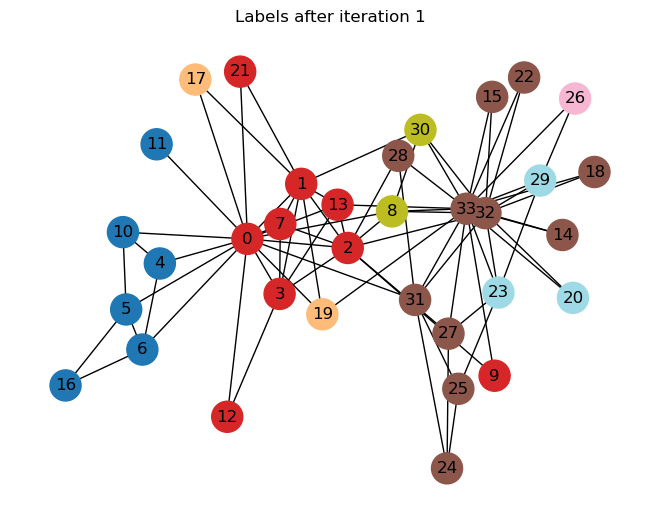

Iteration 02: changed_fraction=0.265, num_communities=4, largest_size=15


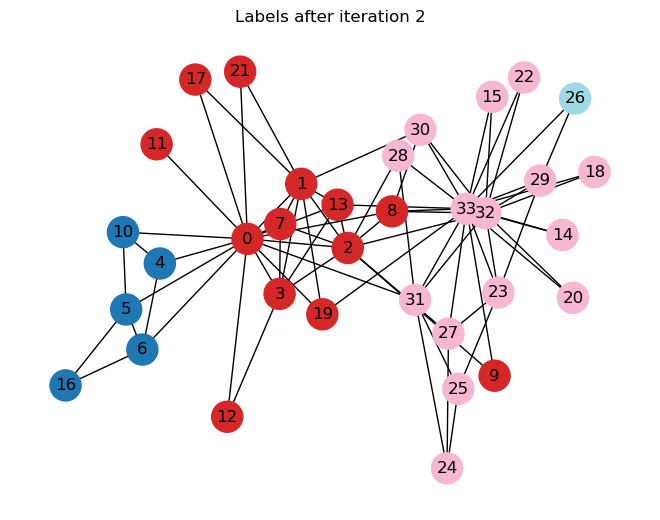

Iteration 03: changed_fraction=0.059, num_communities=3, largest_size=17


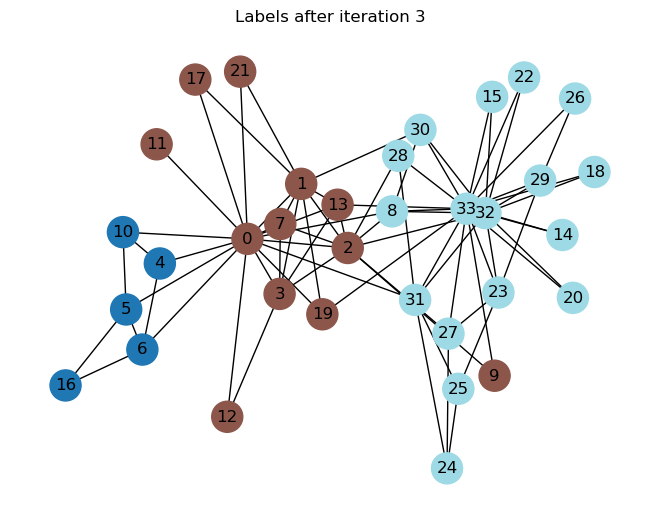

Iteration 04: changed_fraction=0.000, num_communities=3, largest_size=17


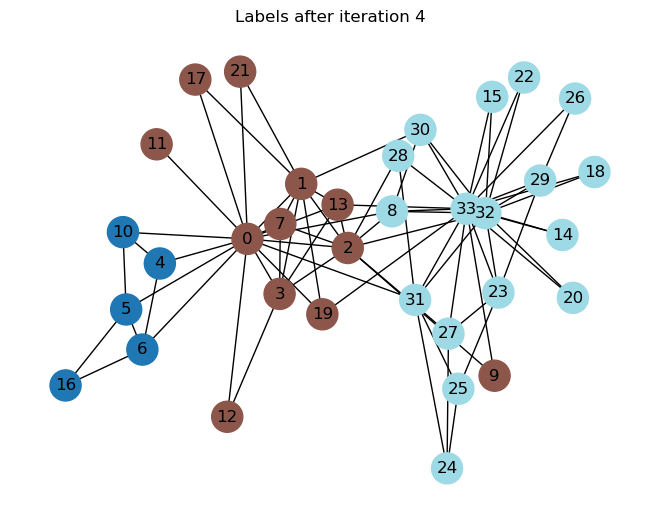

Stopping early at iteration 4 because changed_fraction <= epsilon (1e-16).


In [102]:
history = []

num_to_draw = 5  # draw first 5 iterations
for it in range(1, max_iters + 1):
    changed_fraction = model._single_iteration()
    labels_now = model._labels
    summary = summarize_labels(labels_now)
    history.append((it, changed_fraction, summary["num_communities"], summary["largest_community_size"]))

    print(f"Iteration {it:02d}: changed_fraction={changed_fraction:.3f}, "
          f"num_communities={summary['num_communities']}, "
          f"largest_size={summary['largest_community_size']}")

    if it <= num_to_draw:
        draw_colored(G, pos, labels_now, title=f"Labels after iteration {it}")

    # Stop condition (same logic as model.run)
    if changed_fraction <= model.epsilon:
        print(f"Stopping early at iteration {it} because changed_fraction <= epsilon ({model.epsilon}).")
        break

final_labels = model._labels

## 8) Final communities

Now we group nodes by their final label and print the communities.

In [103]:

print("Number of communities:", len(final_labels))

print(f'\n')
print('Table of vertex number, community')
for key, value in final_labels.items():
    print(key, value)

Number of communities: 34


Table of vertex number, community
0 3
1 3
2 3
3 3
4 0
5 0
6 0
7 3
8 28
9 3
10 0
11 3
12 3
13 3
14 28
15 28
16 0
17 3
18 28
19 3
20 28
21 3
22 28
23 28
24 28
25 28
26 28
27 28
28 28
29 28
30 28
31 28
32 28
33 28


## 9) Final visualization

This is the final community assignment produced by label propagation.

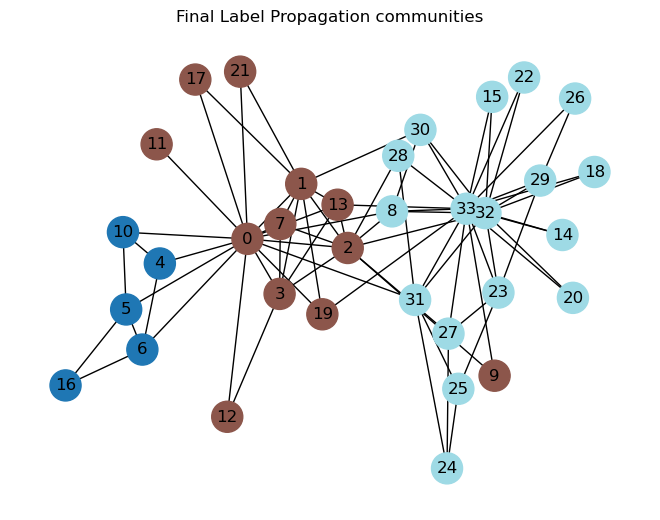

In [104]:
draw_colored(G, pos, final_labels, title="Final Label Propagation communities")

## 10) Compare to the classic “club split” attribute

The Karate Club dataset includes a node attribute named `club` which reflects the historical split:
- `"Mr. Hi"`
- `"Officer"`

We’ll compare those labels to the detected communities.

In [105]:
club = {n: G.nodes[n].get("club") for n in G.nodes()}
mapping = {k: [final_labels[k], club[k]] for k in final_labels}

for key, value in mapping.items():
    print(key, value)

0 [3, 'Mr. Hi']
1 [3, 'Mr. Hi']
2 [3, 'Mr. Hi']
3 [3, 'Mr. Hi']
4 [0, 'Mr. Hi']
5 [0, 'Mr. Hi']
6 [0, 'Mr. Hi']
7 [3, 'Mr. Hi']
8 [28, 'Mr. Hi']
9 [3, 'Officer']
10 [0, 'Mr. Hi']
11 [3, 'Mr. Hi']
12 [3, 'Mr. Hi']
13 [3, 'Mr. Hi']
14 [28, 'Officer']
15 [28, 'Officer']
16 [0, 'Mr. Hi']
17 [3, 'Mr. Hi']
18 [28, 'Officer']
19 [3, 'Mr. Hi']
20 [28, 'Officer']
21 [3, 'Mr. Hi']
22 [28, 'Officer']
23 [28, 'Officer']
24 [28, 'Officer']
25 [28, 'Officer']
26 [28, 'Officer']
27 [28, 'Officer']
28 [28, 'Officer']
29 [28, 'Officer']
30 [28, 'Officer']
31 [28, 'Officer']
32 [28, 'Officer']
33 [28, 'Officer']


We can see that although there are only 2 Dojos (Officer and Mr. Hi), our algorithm is finding 3 clusters. 

## 11) Real world implementation
Above we used community detection in a step by step method. Now lets run it all in one go.

Here we set up our new model (called model2).
The attribute `get_label_vector` allows us to get the final lables in a vector form so that they are easier to work work. The labels are indexed by the numeric name of the vertex.

In [106]:
model2 = community_detection(vertices=V , edges=E , max_iters=max_iters, epsilon=10**(-16)) #initialize our model
final_labels = model2.run(seed=42) #runs community detection to get the final set of labels
communities = model2.get_communities() # 
vec = model2.get_label_vector()

Here we plot the results of model2. We can observe that we get the same result as above

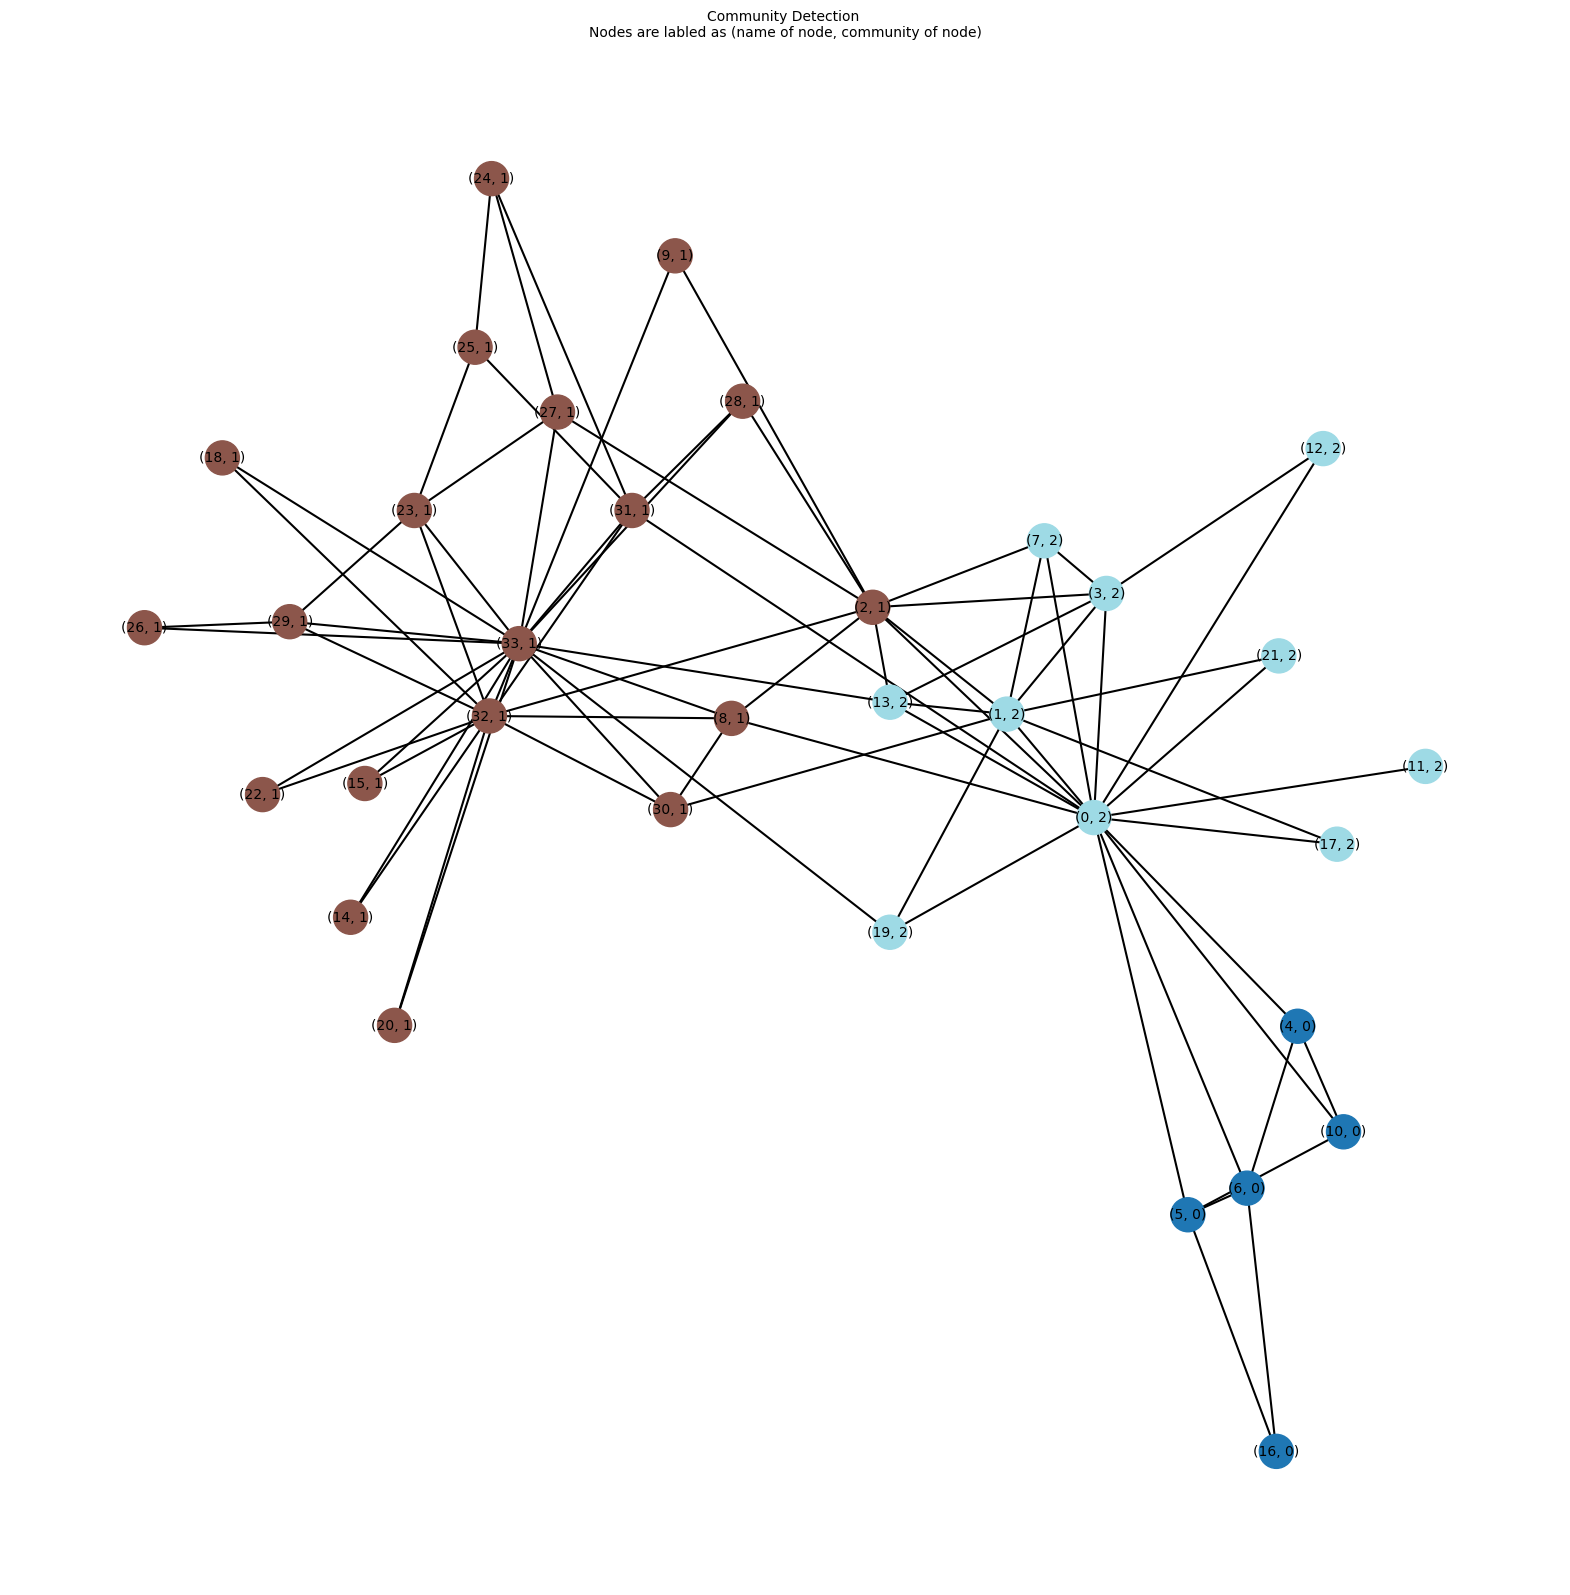

In [107]:
plt.figure(figsize=(20, 20))
dict = {v: vec[i] for i, v in enumerate(V)}
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=list(dict.values()),
    cmap="tab20",
    node_size=600
)
nx.draw_networkx_edges(G, pos, width=1.5)
labels = {v: f"({v}, {dict[v]})" for v in V}
nx.draw_networkx_labels(G, pos, labels, font_size=10)
plt.title("Community Detection \nNodes are labled as (name of node, community of node)", fontsize=10)
plt.axis("off")
plt.show()